## Regresion Lineal

antes de utilizar un modelo de red neuronal, probemos con un sencillo modelo de regresión lineal

Accuracy: 0.5325
Precision: 0.2807
Recall: 0.6295
F1-Score: 0.3883


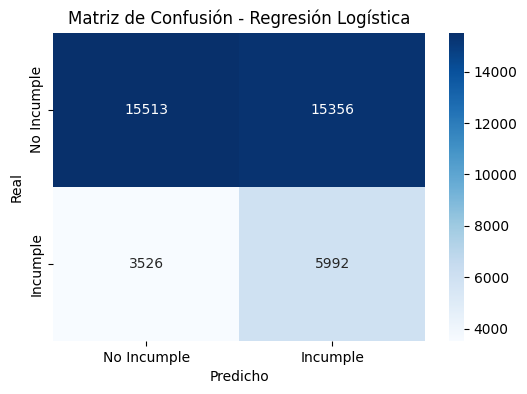

In [4]:
# Importar librerías necesarias
import pandas as pd
import joblib
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar datos
data = pd.read_csv("cleaned_dataset.csv")

# Convertir variables categóricas a numéricas y guardar los LabelEncoders
categorical_features = ['home_ownership']
label_encoders = {}

for col in categorical_features:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))
    label_encoders[col] = le  # Guardar el encoder para su uso posterior

# Selección de características
selected_features = [
    'emp_length', 'home_ownership', 'annual_inc', 'delinq_2yrs', 'open_acc',
    'total_acc', 'tot_cur_bal'
]

# Separar características y etiqueta
X = data[selected_features]
y = data['loan_status']

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Aplicar SMOTE para balancear las clases en el conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Escalar características numéricas y guardar el scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Guardar scaler y LabelEncoders
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')

# Definir y entrenar el modelo de regresión logística
log_reg = LogisticRegression(max_iter=1000, solver='lbfgs', random_state=42)
log_reg.fit(X_train_scaled, y_train_resampled)

# Predicciones
y_pred = log_reg.predict(X_test_scaled)

# Evaluación del modelo
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Mostrar resultados
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Incumple", "Incumple"], yticklabels=["No Incumple", "Incumple"])
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Regresión Logística")
plt.show()


# Selección del Modelo de Red Neuronal para Predicción de Incumplimiento Crediticio

## 1. Justificación de la Elección del Modelo

### Capacidad para Capturar Patrones Complejos
El incumplimiento crediticio no sigue relaciones lineales simples, sino que depende de múltiples factores como ingresos, historial crediticio y características del préstamo. La red neuronal permite modelar estas interacciones no lineales de manera eficiente.

### Versatilidad y Adaptabilidad
Las redes neuronales pueden ajustarse a diferentes tipos de datos y escalas. En este caso, el modelo ha sido optimizado para procesar datos tabulares preprocesados, con una arquitectura diseñada para equilibrar capacidad predictiva y eficiencia computacional.

### Uso de Mixed Precision
Se implementó **Mixed Precision Training** para mejorar la velocidad de entrenamiento y reducir el consumo de memoria en GPUs, lo que permite escalar el modelo a conjuntos de datos más grandes sin comprometer el rendimiento.

### Manejo de Datos Desbalanceados con `class_weight`
Dado que los datos presentan un desbalance entre clientes incumplidores y no incumplidores, se utilizó **ponderación de clases (`class_weight`)** en lugar de `binary_crossentropy` estándar sin pesos. Esto ayuda a mejorar la detección de la clase minoritaria sin necesidad de técnicas como **SMOTE** o funciones de pérdida personalizadas como **Focal Loss**.


---

## 2. Descripción del Modelo

### Arquitectura del Modelo

1. **Entrada**:
   - El número de neuronas en la capa de entrada equivale al número de características preprocesadas.

2. **Capas Ocultas**:
   - **Primera Capa Oculta**:
     - Neuronas: 1024
     - Activación: Leaky ReLU
     - Regularización L2: 0.01
     - Dropout: 30%
   - **Segunda Capa Oculta**:
     - Neuronas: 512
     - Activación: Leaky ReLU
     - Regularización L2: 0.01
     - Dropout: 30%
   - **Tercera Capa Oculta**:
     - Neuronas: 512
     - Activación: Leaky ReLU
     - Regularización L2: 0.01
     - Dropout: 30%
   - **Cuarta Capa Oculta**:
     - Neuronas: 256
     - Activación: Leaky ReLU
     - Regularización L2: 0.01
     - Dropout: 30%
   - **Quinta Capa Oculta**:
     - Neuronas: 128
     - Activación: Leaky ReLU
     - Regularización L2: 0.01
     - Dropout: 20%
   - **Sexta Capa Oculta**:
     - Neuronas: 64
     - Activación: Leaky ReLU
     - Regularización L2: 0.01
   - **Séptima Capa Oculta**:
     - Neuronas: 32
     - Activación: Leaky ReLU
     - Regularización L2: 0.01

3. **Salida**:
   - Neurona: 1
   - Activación: Sigmoid (para generar probabilidad de incumplimiento).

### Parámetros de Compilación
- **Función de pérdida**: `binary_crossentropy` con ponderación de clases (`class_weight`).
- **Optimizador**: Adam con `learning_rate=5e-5` (reducida para estabilizar la convergencia).
- **Métrica de evaluación**: Precisión (`accuracy`), pero con énfasis en recall y F1-score.

---

## 3. Análisis del Dataset y Características Utilizadas

El modelo se entrena con datos preprocesados que incluyen:

- **Variables relacionadas con el historial crediticio**:
  - Número de cuentas abiertas (`open_acc`)
  - Número total de cuentas (`total_acc`)
  - Cantidad total de saldo actual de crédito (`tot_cur_bal`)
  - Atrasos en pagos (`delinq_2yrs`)

- **Variables relacionadas con el solicitante**:
  - Ingresos anuales (`annual_inc`)
  - Antigüedad laboral (`emp_length`)
  - Estado de la vivienda (`home_ownership`)

Estas características fueron seleccionadas en base a su relevancia en la evaluación de riesgo de crédito.

---

## 4. Comparación con Otros Modelos

### **¿Por qué una Red Neuronal y no otro modelo?**

| Modelo | Ventajas | Desventajas |
|--------|----------|------------|
| **Regresión Logística** | Simplicidad, interpretabilidad | No captura relaciones no lineales |
|
| **Red Neuronal (Este modelo)** | Captura relaciones no lineales, escalabilidad | Mayor demanda computacional y ajuste de hiperparámetros |

El modelo de red neuronal fue seleccionado debido a su capacidad para aprender representaciones complejas y su escalabilidad para grandes volúmenes de datos.

---

## 5. Mejoras Implementadas

1. **Aumento del Tamaño del Batch (`batch_size=512`)**
   - Reduce la variabilidad en la curva de pérdida y estabiliza el entrenamiento.
2. **Reducción de la Tasa de Aprendizaje (`learning_rate=5e-5`)**
   - Evita que el modelo fluctúe demasiado en la optimización, mejorando la estabilidad.




## 1. Normalización de los datos, Construcción, Compilación y Entrenamiento del Modelo


( el modelo fue entrenado en Google Colab haciendo uso de GPU T4)

In [ ]:
import pandas as pd
import joblib
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision
import tensorflow as tf

# Habilitar Mixed Precision
mixed_precision.set_global_policy("mixed_float16")

# Cargar datos
data = pd.read_csv("cleaned_dataset.csv")

# Convertir variables categóricas a numéricas y guardar los LabelEncoders
categorical_features = ['home_ownership']
label_encoders = {}

for col in categorical_features:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))
    label_encoders[col] = le  # Guardar el encoder para su uso posterior

# Selección de características
selected_features = [
    'emp_length', 'home_ownership', 'annual_inc', 'delinq_2yrs', 'open_acc',
    'total_acc', 'tot_cur_bal'
]

# Separar características y etiqueta
X = data[selected_features]
y = data['loan_status']

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar características numéricas y guardar el scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Guardar scaler y LabelEncoders
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')

print("✅ StandardScaler y LabelEncoders guardados correctamente.")

# Calcular los pesos de clase para balancear el entrenamiento
class_weights = dict(enumerate(compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)))

# Construir el modelo con Mixed Precision
model = Sequential([
    Dense(1024),
    LeakyReLU(alpha=0.1),
    Dropout(0.3),
    Dense(512),
    LeakyReLU(alpha=0.1),
    Dropout(0.3),
    Dense(512),
    LeakyReLU(alpha=0.1),
    Dropout(0.3),
    Dense(256),
    LeakyReLU(alpha=0.1),
    Dropout(0.3),
    Dense(128),
    LeakyReLU(alpha=0.1),
    Dropout(0.2),
    Dense(64),
    LeakyReLU(alpha=0.1),
    Dense(32),
    LeakyReLU(alpha=0.1),
    
    # Última capa en float32 para estabilidad numérica
    Dense(1, activation='sigmoid', dtype="float32")  
])

# Optimizador con soporte para Mixed Precision
optimizer = Adam(learning_rate=0.000002)

# Compilar el modelo con Binary Cross-Entropy y class_weight
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=['accuracy'])

# Guardar solo los mejores pesos basados en la menor pérdida en validación
checkpoint = ModelCheckpoint("best_model.keras", save_best_only=True, monitor='val_loss', mode='min')

# Early stopping para evitar sobreajuste
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# Entrenar el modelo con class_weight
history = model.fit(X_train_scaled, y_train, epochs=300, batch_size=512, validation_split=0.2, 
                    verbose=1, callbacks=[checkpoint, early_stopping], class_weight=class_weights)

# Cargar el mejor modelo guardado
best_model = load_model("best_model.keras")

# Evaluar el mejor modelo
eval_results = best_model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"\nEvaluación del mejor modelo:\nPérdida: {eval_results[0]:.4f}\nPrecisión: {eval_results[1]:.4f}")


## Evaluación del modelo

c:\Users\samue\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 34 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1263/1263 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step
 Evaluación del Modelo de Red Neuronal:
 Accuracy: 0.5693
 Precision: 0.2917
 Recall: 0.5797
 F1-Score: 0.3882


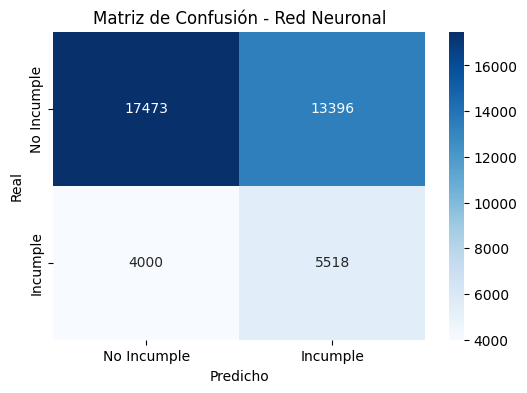

In [5]:
# Importar librerías necesarias
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.models import load_model
import joblib

# Cargar el mejor modelo guardado
best_model = load_model("best_model.keras")  # Ajusta según el fold que prefieras evaluar

# Cargar el scaler correspondiente
scaler = joblib.load("scaler.pkl")  

# Normalizar los datos de prueba
X_test_scaled = scaler.transform(X_test)  

# Realizar predicciones
y_pred_proba = best_model.predict(X_test_scaled)  # Obtener probabilidades de la clase positiva
y_pred = (y_pred_proba > 0.5).astype(int)  # Convertir probabilidades en clases binarias

# Evaluación del modelo
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Mostrar resultados
print(f" Evaluación del Modelo de Red Neuronal:")
print(f" Accuracy: {accuracy:.4f}")
print(f" Precision: {precision:.4f}")
print(f" Recall: {recall:.4f}")
print(f" F1-Score: {f1:.4f}")

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Incumple", "Incumple"], yticklabels=["No Incumple", "Incumple"])
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Red Neuronal")
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from predictor import predecir_incumplimiento

# Cargar el dataset
df = pd.read_csv("cleaned_dataset.csv")

# Lista de características utilizadas en el modelo
feature_names = [
    'emp_length', 'home_ownership', 'annual_inc', 'delinq_2yrs', 'open_acc',
    'total_acc', 'tot_cur_bal'
]

# Filtrar solo las columnas utilizadas
df = df[feature_names]

# Calcular las probabilidades de incumplimiento para cada fila del dataset
probabilidades = df.apply(lambda row: predecir_incumplimiento(row.tolist()), axis=1)

# Agregar las probabilidades al DataFrame
df['probabilidad_incumplimiento'] = probabilidades

# Guardar los resultados en un nuevo archivo CSV
df.to_csv("dataset_con_probabilidades.csv", index=False)

# Graficar la distribución de las probabilidades de incumplimiento
plt.figure(figsize=(10, 6))
plt.hist(probabilidades, bins=30, color='blue', edgecolor='black')
plt.title("Distribución de Probabilidades de Incumplimiento")
plt.xlabel("Probabilidad de Incumplimiento")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from predictor import predecir_probabilidad  # Asegúrate de importar la función correcta

# Cargar el dataset
df = pd.read_csv("cleaned_dataset.csv")

# Lista de características utilizadas en el modelo
feature_names = [
    'emp_length', 'home_ownership', 'annual_inc', 'delinq_2yrs', 'open_acc',
    'total_acc', 'tot_cur_bal'
]

# Filtrar solo las columnas utilizadas en el modelo
df = df[feature_names]

# Convertir cada fila a diccionario y calcular probabilidades en un solo paso
inputs = df.to_dict(orient="records")
probabilidades = np.array([predecir_probabilidad(row) for row in inputs])

# Agregar las probabilidades al DataFrame
df['probabilidad_incumplimiento'] = probabilidades

# Guardar los resultados en un nuevo archivo CSV
df.to_csv("dataset_con_probabilidades.csv", index=False)

# Graficar la distribución de las probabilidades de incumplimiento
plt.figure(figsize=(10, 6))
plt.hist(probabilidades, bins=20 if len(probabilidades) > 100 else 10, color='blue', edgecolor='black')
plt.title("Distribución de Probabilidades de Incumplimiento")
plt.xlabel("Probabilidad de Incumplimiento")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()
